# Plot changes in the Metabolic index

In [10]:
%matplotlib inline
import xarray as xr
import numpy as np
import os

import grid_tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point
import plot_tools
from config_calc import *
import cmocean
plt.rcParams['mathtext.default']='regular'

### make grid

In [11]:
nx = 360
ny = 180
grid = grid_tools.generate_latlon_grid(nx=nx,ny=ny,lon0=0.)
grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, nv: 4)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: nv
Data variables:
    xc       (lat, lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    yc       (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    xv       (lat, lon, nv) float64 0.0 1.0 1.0 0.0 1.0 2.0 2.0 1.0 2.0 3.0 ...
    yv       (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 -90.0 -90.0 ...
    area     (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 1.079e+08 ...

In [12]:
depth = xr.DataArray(np.concatenate((np.arange(0.,40.,10.),
                                     np.arange(50.,175.,25.),
                                     np.arange(200.,350.,50.),
                                     np.arange(400.,1600.,100.),
                                     np.arange(1750.,2000.,250.),
                                     np.arange(2000.,6000.,500.))),dims=('depth'))
depth

<xarray.DataArray (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,   150.,
         200.,   250.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1750.,  2000.,  2500.,
        3000.,  3500.,  4000.,  4500.,  5000.,  5500.])
Dimensions without coordinates: depth

### load data from Curtis

In [13]:
import scipy.io as sio
matdata = sio.loadmat('data/IUCN_metab_idx.mat')

dphi = xr.DataArray(matdata['dphiA'],dims=('lon','lat','depth'),coords={'lon':grid.lon,'lat':grid.lat,'depth':depth})
dphi = xr.Dataset({'dphi':dphi,'lat':grid.lat,'lon':grid.lon,'depth':depth})
dphi = dphi.transpose('depth','lat','lon')
dphi

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360)
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Data variables:
    dphi     (depth, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

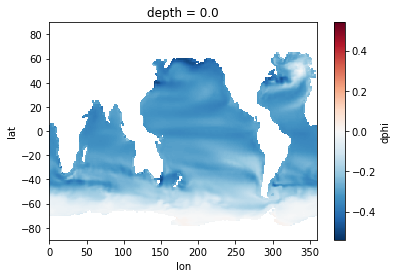

In [14]:
dphi.dphi[0,:,:].plot()

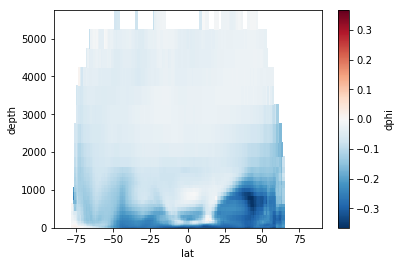

In [15]:
dphi.dphi.mean(dim='lon').plot()

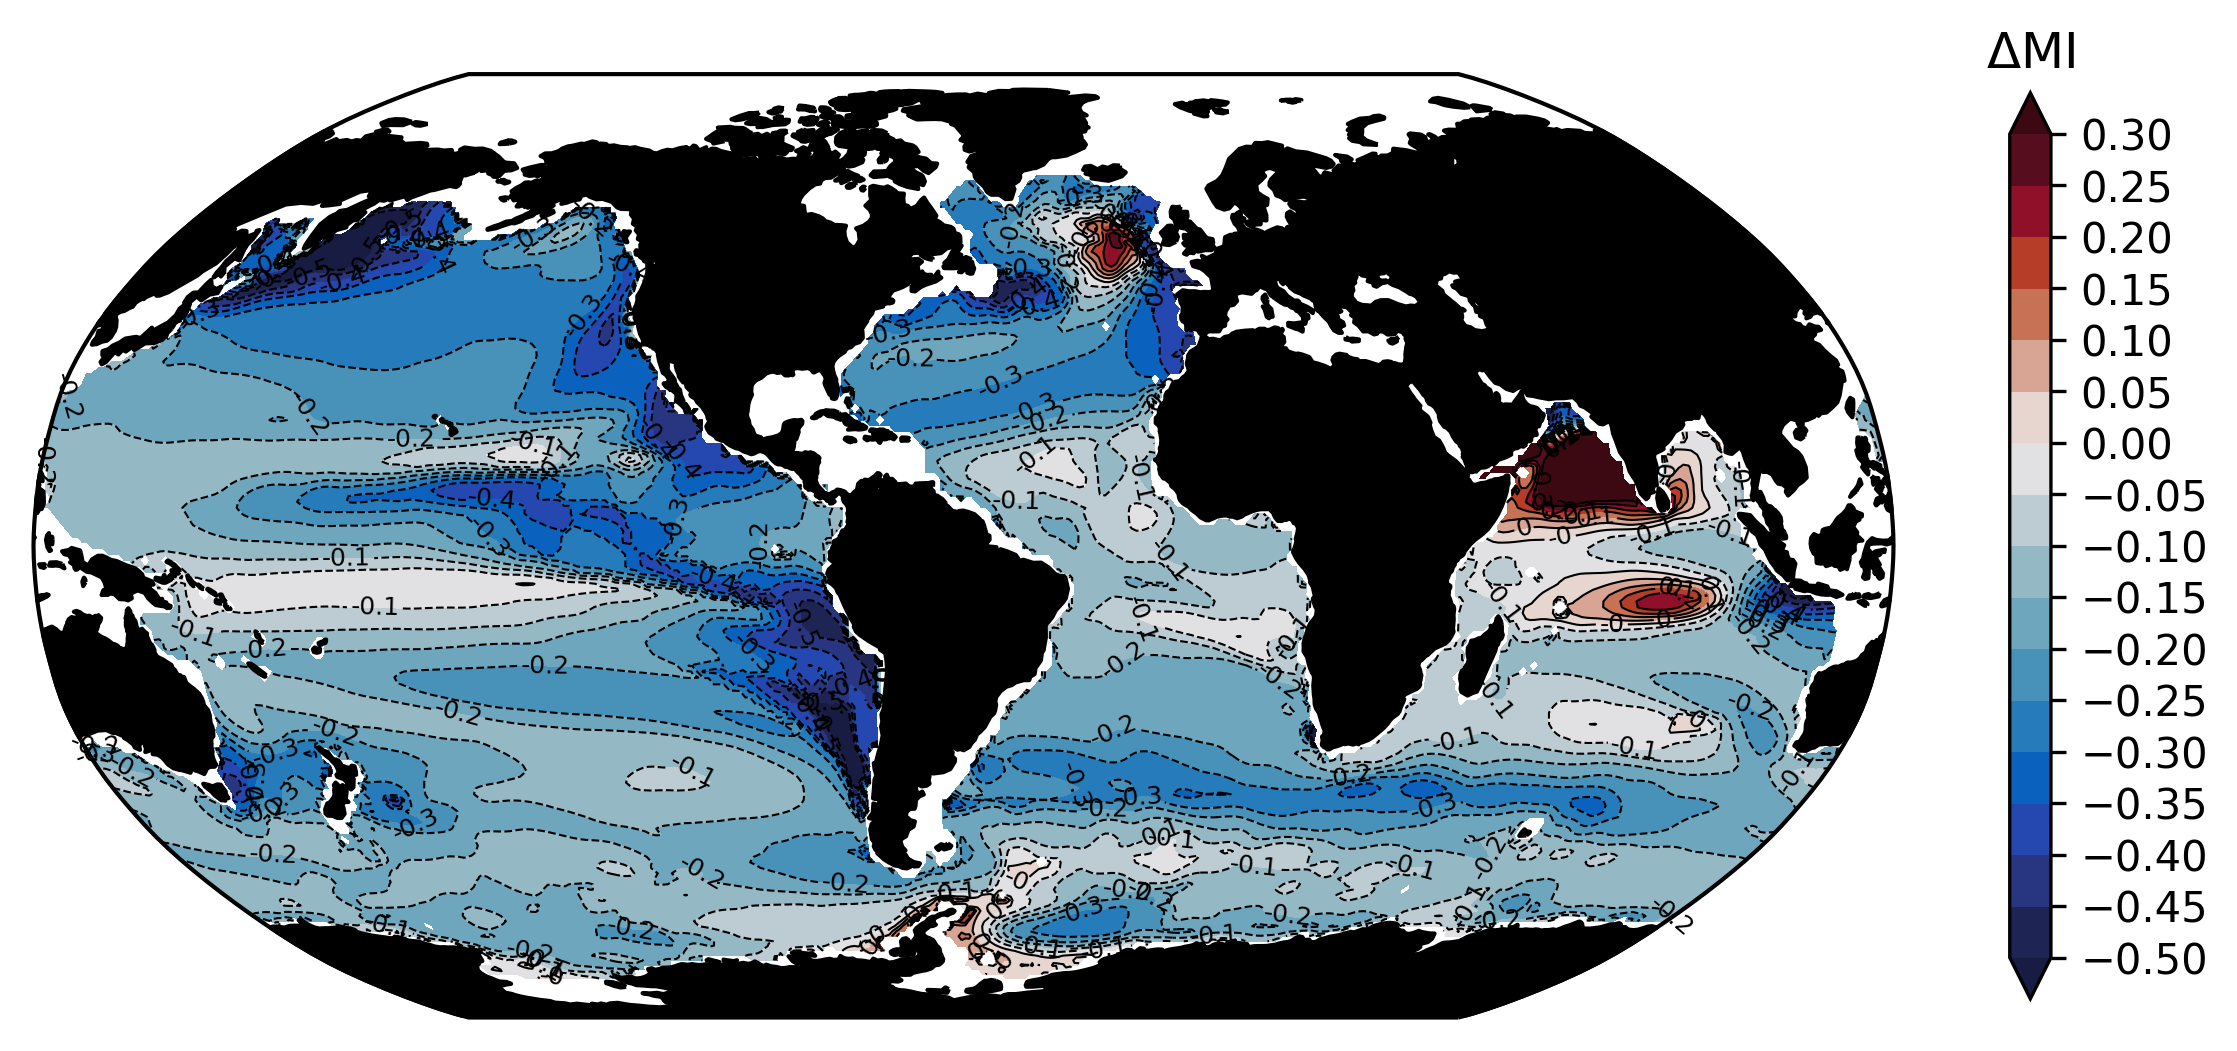

In [38]:
plot_name = os.path.join(diro['fig'],'metabolic-index-change-map.pdf')

units = '$\Delta$MI'
levels = np.arange(-0.5,0.35,0.05)

fig=plt.figure(figsize=(10, 8),dpi=300)
gs = gridspec.GridSpec(1,1)

norm = plot_tools.MidPointNorm(midpoint=0)
contour_specs = {'levels':levels,'cmap':cmocean.cm.balance,'norm':norm,'extend':'both'}

z = dphi.dphi.sel(depth=slice(200,600)).mean(dim='depth').values
lat = dphi.lat.values
lon = dphi.lon.values

lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

obj = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                            contour_specs,
                                            units = units,
                                            fig=fig,
                                            gridspec=gs,
                                            row=0,col=0)
plt.savefig(plot_name,bbox_inches='tight')

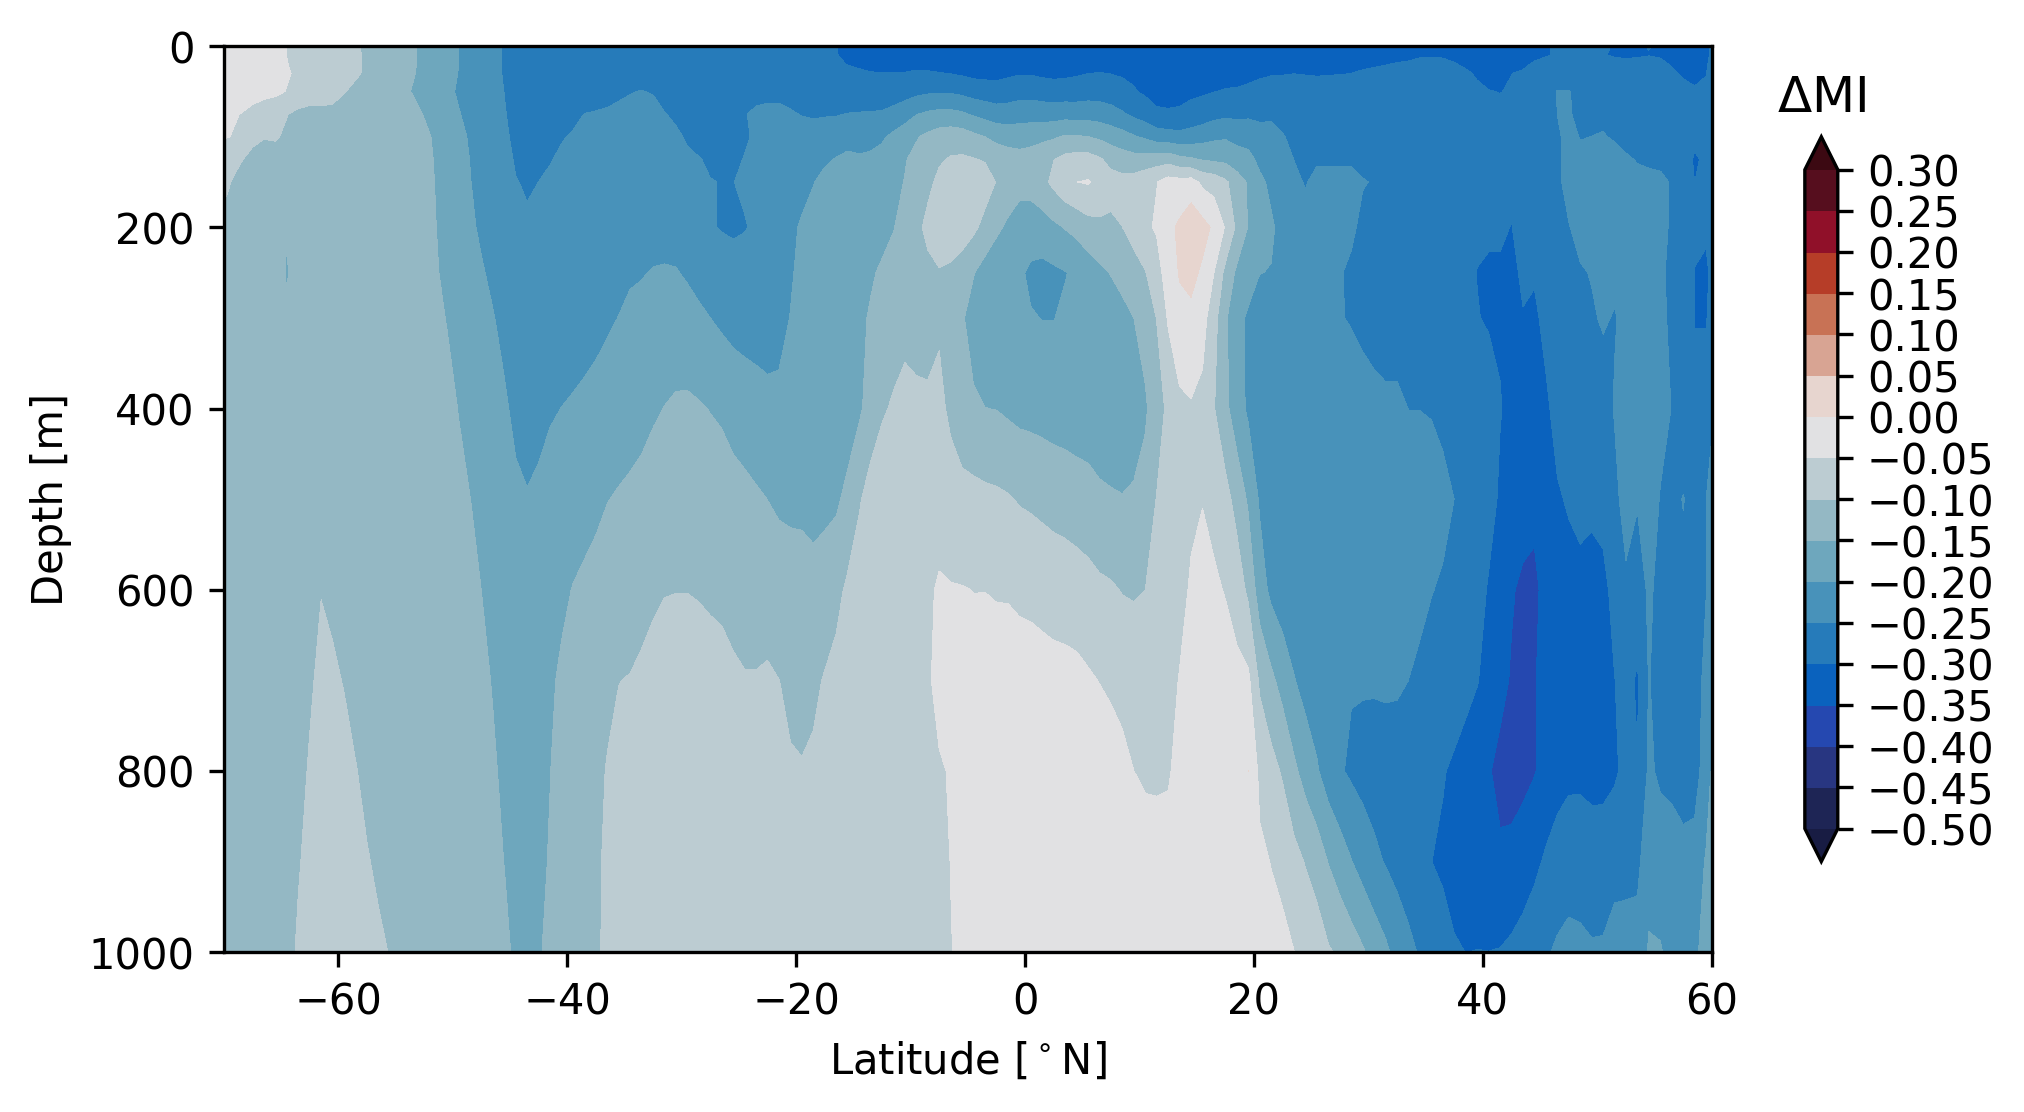

In [40]:
plot_name = os.path.join(diro['fig'],'metabolic-index-change-zonal.pdf')

fig=plt.figure(figsize=(8, 4),dpi=300)
gs = gridspec.GridSpec(1,1)

lat = dphi.lat.values
depth = dphi.depth.values
z = dphi.dphi.mean(dim='lon').values
ax = fig.add_subplot(gs[0,0])
cf = ax.contourf(lat,depth, z, **contour_specs)  
ax.set_ylim((1000.,0.))
ax.set_xlim(-70,60)
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Depth [m]')

cb = fig.colorbar(cf,ax = ax,
                  ticks = contour_specs['levels'],
                  orientation = 'vertical',
                  shrink = 0.8)
cb.ax.set_title(units)

plt.savefig(plot_name,bbox_inches='tight')